# Neural Machine Translation with Attention
We train a sequence-to-sequence model (seq2seq) mdoel for Spanish to English translation. 

In [1]:
from __future__ import absolute_import, print_function, division, unicode_literals

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os 
import io
import time

tf.enable_eager_execution()

## Load and Preprocess Data
We use a language dataset provided by http://www.manythings.org/anki/. This dataset contains language translation pairs in fhe format:

    May I borrow this book? ¿Puedo tomar este libro?

We will take the following steps to preprocess the data:

1. Add a *start* and *end* token to each sentence. 
2. Clean the sentences by removing special characters.
3. Create a word index and reverse word index. 
4. Pad each sentence to maximum length.

In [0]:
# download the file
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip',
    origin='https://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True 
)
path_to_file = os.path.dirname(path_to_zip) + "/spa-eng/spa.txt"

In [0]:
# convert unicode encoding to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) 
        if unicodedata.category(c) != 'Mn')
    

def preprocess_sentence(sentence):
    sentence = unicode_to_ascii(sentence.lower().strip())
    
    # create a space between a word and the punctuation following it
    # e.g. "she is a girl!" becomes "she is a girl !"
    sentence = re.sub(r"([?.!,¿])", r" \1", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # replace everything with a space except (a-Z, A-Z, ".", "!", "?", ",", "¿")
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)

    sentence = sentence.lower().strip()

    # add a start and end token to each sentence
    # so model knows when to start and stop predicting
    sentence = "<start> " + sentence + " <end>"

    return sentence

In [4]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"

print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbfpuedo tomar prestado este libro ? <end>'


In [0]:
# remove accents, clean sentences, return word pairs in 
# format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')] 
                  for l in lines[:num_examples]]
    
    return zip(*word_pairs)

In [6]:
en, sp = create_dataset(path_to_file, None)

print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [0]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [0]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
        filters=''
    )
    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(
        tensor, padding='post'
    )

    return tensor, lang_tokenizer

In [0]:
def load_dataset(path, num_examples=None):
    # create cleaned input, output pairs
    target_lang, input_lang = create_dataset(path, num_examples)

    input_tensor, input_lang_tokenizer = tokenize(input_lang)
    target_tensor, target_lang_tokenizer = tokenize(target_lang)

    return input_tensor, target_tensor, input_lang_tokenizer, target_lang_tokenizer

### Limit Size of Dataset (Optional)
Training on the complete dataset of >100,000 sentences will take a long time. To train faster, we can limit the size of the data set to 30-50K (at the expense of translation quality, of course).

In [0]:
# you can try experimenting with the size of the dataset
num_examples = 50000
input_tensor, target_tensor, input_lang, target_lang = load_dataset(
    path_to_file, num_examples
)

# calculate max_length of the target tensors
max_length_target, max_length_input = max_length(target_tensor), max_length(input_tensor)

In [11]:
# create training and test sets using 80/20 split
input_tensor_train, input_tensor_test, target_tensor_train, target_tensor_test = train_test_split(input_tensor, target_tensor, test_size=0.2)

print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_test), len(target_tensor_test))

40000 40000 10000 10000


In [0]:
def convert(lang, tensor):
    for t in tensor:
        if t != 0:
            print("%d -----> %s" % (t, lang.index_word[t]))

In [13]:
print("input language; index to word mapping")
convert(input_lang, input_tensor_train[0])
print()
print("target language; index to word mapping")
convert(target_lang, target_tensor_train[0])

input language; index to word mapping
1 -----> <start>
59 -----> ¿por
10 -----> que
693 -----> dios
14 -----> me
15 -----> esta
11665 -----> castigando
4 -----> ?
2 -----> <end>

target language; index to word mapping
1 -----> <start>
73 -----> why
8 -----> is
645 -----> god
6034 -----> punishing
16 -----> me
6 -----> ?
2 -----> <end>


### Create a tf.data Dataset

In [0]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE 
embedding_dim = 256
units = 1024
vocab_input_size = len(input_lang.word_index) + 1
vocab_target_size = len(target_lang.word_index) + 1

dataset = tf.data.Dataset.from_tensor_slices(
    (input_tensor_train, target_tensor_train))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [15]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([Dimension(64), Dimension(16)]),
 TensorShape([Dimension(64), Dimension(12)]))

## Write Encoder and Decoder Model 
We implement an encoder-decoder model with attention which you can read more about [here](https://github.com/tensorflow/nmt). This tutorial implements the [attention equations](https://github.com/tensorflow/nmt#background-on-the-attention-mechanism) from the aforementioned seq2seq tutorial. The diagram below shows that each input word is assigned a weight by the attention mechanism which is then used by the decoder to predict the next word in the sentence. More can be read from [Luong's paper](https://arxiv.org/abs/1508.04025v5). 

![](https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg)

The input is put through an encoder model which gives us the encoder output of shape `(batch_size, max_length, hidden_size)` and the encoder hidden state of shape `(batch_size, hidden_size)`. 

Here are the equations that are implemented:

$$
\begin{aligned}
& \alpha_{ts} = \frac{\exp{\big(\text{score}(h_{t}, \bar{h}_{s}) \big)}}{\sum_{s'=1}^{S}\exp{\big( \text{score}(h_{t}, \bar{h}_{s'} \big)}} && \text{[Attention Weights]} & (1) \\\\
& c_{t} = \sum_{s}{\alpha_{ts}\bar{h}_{s}} && \text{[Context Vector]} & (2) \\\\
& \alpha_{t} = f(c_{t}, h_{t})
= \tanh{\big(\mathbf{W}_{c}\big[ c_{i} ; h_{t} \big] \big)}  && \text{[Attention Vector]} & (3) \\\\
& \text{score}(h_{t}, \bar{h}_{s}) = 
\begin{cases}
h_{t}^\intercal\mathbf{W}\bar{h}_{s} &&&& \text{[Luong's multiplicative style]} \\
v_{\alpha}^\intercal \tanh{\big( \mathbf{W}_{1}h_{t} + \mathbf{W}_{2}\bar{h}_{s}\big)} &&&& \text{[Bahdanau's additive style]}
\end{cases}
\end{aligned} 
$$

We use [Bahdanau attention](https://arxiv.org/pdf/1409.0473.pdf) for the encoder. Some important notations for our purposes:

- `FC` = Fully Connected Layer
- `EO` = Encoder Output
- `H` = Hidden State
- `X` = Input to the Decoder

...and the pseudo-code:
- `score=FC(tanh(FC(EO) + FC(H)))` 
- `attention weights = softmax(score, axis = 1)`. Softmax by default is applied on the last axis but we want to apply it on the 1st axis (not -1), since the shape of score is `(batch_size, max_length, hidden_size)`. `max_length` is the length of our input. Since we are trying to assign a weight to each input, softmax should be applied on that axis. 
- `context vector = sum(attention weights * EO, axis = 1)`. Same reason as above for choosing axis as 1. 
- `merged vector = concat(embedding output, context vector)`.
- The merged vector is then given to the [GRU](https://en.wikipedia.org/wiki/Gated_recurrent_unit). 


In [0]:
class Encoder(tf.keras.Model):

    def __init__(self, vocab_size, embedding_dim, enc_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units, 
                                       return_sequences=True, 
                                       return_state=True, 
                                       recurrent_initializer='glorot_uniform')
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.enc_units))

In [17]:
encoder = Encoder(vocab_input_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)

print("Encoder output shape: (batch_size, seq_len, units): {}".format(
    sample_output.shape))
print("Encoder hidden state shape: (batch size, units) {}".format(
    sample_hidden.shape))

Encoder output shape: (batch_size, seq_len, units): (64, 16, 1024)
Encoder hidden state shape: (batch size, units) (64, 1024)


In [0]:
class BahdanauAttention(tf.keras.layers.Layer):

    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        # we do this to perform ddition to calculate the score
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_lengths, units)
        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)
        ))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # contect_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights 


In [19]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


In [0]:
class Decoder(tf.keras.Model):

    def __init__(self, vocab_size, embedding_dim, dec_units, batch_size):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units, 
                                       return_sequences=True, 
                                       return_state=True, 
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention 
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1) 

        # pass the concatenated vector the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [21]:
decoder = Decoder(vocab_target_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 6820)


## Define Optimizer and Loss Function

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

## Set Up Checkpoints (Object-based Saving) 

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, 
                                 encoder=encoder, 
                                 decoder=decoder)

## Training
1. Pass the input through the encoder which returns encoder output and encoder hidden state.
2. The encoder output, encoder hidden state and the decoder input (which is the start token) is passed to the decoder. 
3. The decoder returns the predictions and the decoder hidden state. 
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss. 
5. Use teacher forcing to decide the next input to the decoder. 
6. Teacher forcing is the technique where the target word is passed as the next input to the decoder. 
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate. 

In [0]:
@tf.function
def train_step(inp, target, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden
        dec_input = tf.expand_dims(
            [target_lang.word_index['<start>']] * BATCH_SIZE, 1)
        
        # teacher forcing - feeding the target as the next input
        for t in range(1, target.shape[1]):
            # passing enc_output to decoder
            predictions, dec_hidden, _ = decoder(dec_input, 
                                                 dec_hidden, enc_output)
            
            loss += loss_function(target[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, t], 1)

        batch_loss = (loss / int(target.shape[1]))
        variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))

        return batch_loss

In [25]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, target)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, target, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print("Epoch {} Batch {} Loss {:.4f}".format(epoch+1, 
                                                         batch, 
                                                         batch_loss.numpy()))
            
            # saving (checkpoint) the mdoel every 2 epochs
    if (epoch + 1) % 2 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
    print("Epoch {} Loss {:.4f}".format(epoch+1, 
                                        total_loss /steps_per_epoch))
    print("Time taken for 1 epoch {} sec\n".format(time.time() - start))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1 Batch 0 Loss 4.7700
Epoch 1 Batch 100 Loss 2.3815
Epoch 1 Batch 200 Loss 2.1082
Epoch 1 Batch 300 Loss 1.8406
Epoch 1 Batch 400 Loss 1.6718
Epoch 1 Batch 500 Loss 1.6319
Epoch 1 Batch 600 Loss 1.3284
Epoch 1 Loss 1.9353
Time taken for 1 epoch 217.24317169189453 sec

Epoch 2 Batch 0 Loss 1.3738
Epoch 2 Batch 100 Loss 1.3911
Epoch 2 Batch 200 Loss 1.2915
Epoch 2 Batch 300 Loss 1.2162
Epoch 2 Batch 400 Loss 1.0742
Epoch 2 Batch 500 Loss 1.0467
Epoch 2 Batch 600 Loss 0.8213
Epoch 2 Loss 1.1402
Time taken for 1 epoch 185.2908535003662 sec

Epoch 3 Batch 0 Loss 0.8635
Epoch 3 Batch 100 Loss 0.8628
Epoch 3 Batch 200 Loss 0.8171
Epoch 3 Batch 300 Loss 0.7954
Epoch 3 Batch 400 Loss 0.6665
Epoch 3 Batch 500 Loss 0.6278
Epoch 3 Batch 600 Loss 0.4766
Epoch 3 Loss 0.7066
Time taken for 1 epoch 183.79998779296875 sec

Epoch 4 Batch 0 Loss 0.5723
Epoch 4 Batch 100 Loss 0.5915
Epoch 4 Batch 200 Loss 0

## Translate

In [0]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_target, max_length_input))

    sentence = preprocess_sentence(sentence)

    inputs = [input_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], 
                                                           maxlen=max_length_input, 
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([target_lang.word_index['<start>']], 0)

    for t in range(max_length_target):
        predictions, dec_hidden, attention_weights = decoder(dec_input, 
                                                             dec_hidden, 
                                                             enc_out)
        
        # storing attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += target_lang.index_word[predicted_id] + ' '
        
        if target_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # if predited ID is fed back into the model 
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [0]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print("Input: %s" % (sentence))
    print("Predicted translation: {}".format(result))

    attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

### Restore Latest Checkpoint and Test

In [44]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> como te llamas ? <end>
Predicted translation: what s your name ? <end> 


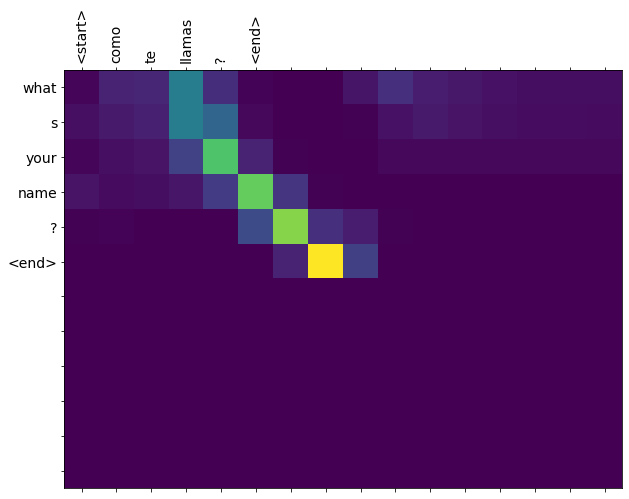

In [48]:
translate(u'como te llamas?')

Input: <start> esta es mi vida <end>
Predicted translation: this is my life . <end> 


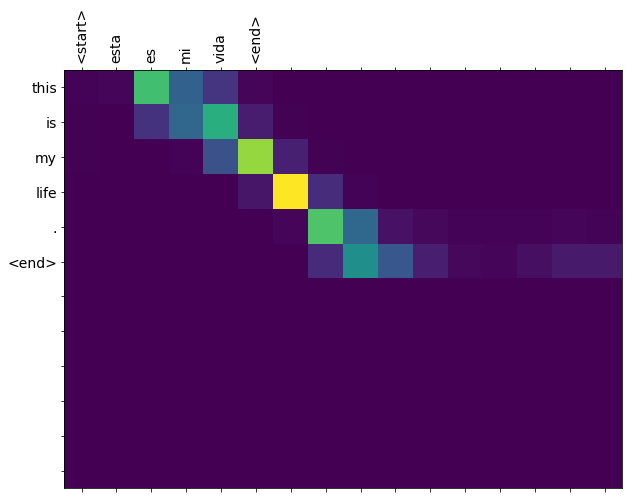

In [49]:
translate(u'esta es mi vida')

Input: <start> ¿todavia estan en casa ? <end>
Predicted translation: are you at home ? <end> 


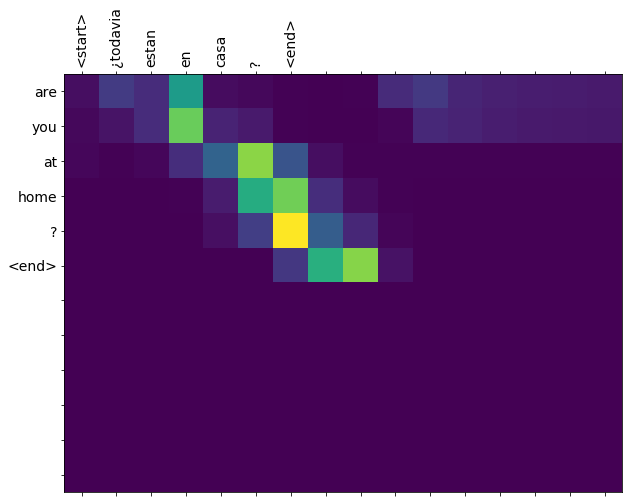

In [50]:
translate(u'¿todavia estan en casa?')

Input: <start> un momento por favor <end>
Predicted translation: for a moment , please . <end> 


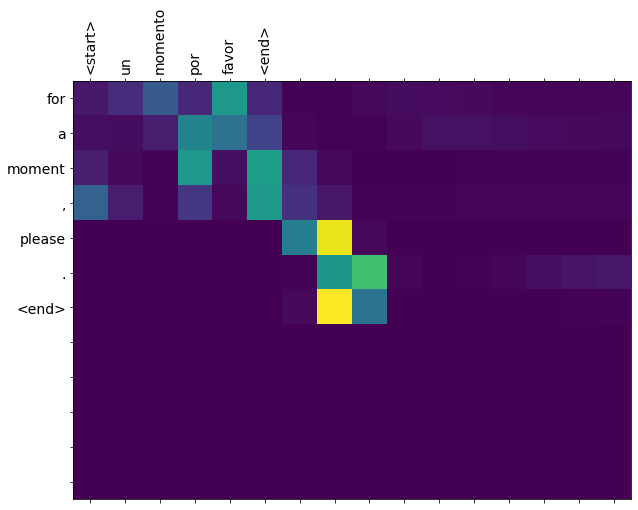

In [51]:
translate(u'un momento por favor')